# **Web Scraping Financial Documents in Python**

In [ ]:
import pandas as pd
from functools import reduce

## **Lesson Outline**

In this lesson we learn how to pull .html SEC filing data for any public (listed) US company.


In particular, in this lesson we pull NVDA and AAPL SEC 10-Q financial statement data from all 2023 fillings and combine them in one list of datasets ready for EDA (Exploratory Data Analysis).


This method although much less streamlined than using data (fundemental data) from API's is a free way we can pull as much data as we please without hitting any request limit.

*Written by: Amjad Saidam*

# **Web Scraping Functions**

If we run the following cell, we see that we pull all tables from the .html page. We require more data processing so that we can pull specific tables.

*note the link used below is "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/ac7583b0-c5c4-402a-bb92-41e18a7f0e1e.html"*

In [ ]:
url = "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/ac7583b0-c5c4-402a-bb92-41e18a7f0e1e.html"
tabels = pd.read_html(url)
#type(tabels)
#tabels

1) Define `calls()` that pulls data from the required .html file.





In [ ]:
def calls(urls):
  res = []
  for url in urls:
    res.append(pd.read_html(url))
  return res



2) We construct `normalise_columns()`, this function flattens multi-level column headers.

Below is an example of a column with multiple headers, we need to standerdise such columns so that we can transform it to a dataframe.

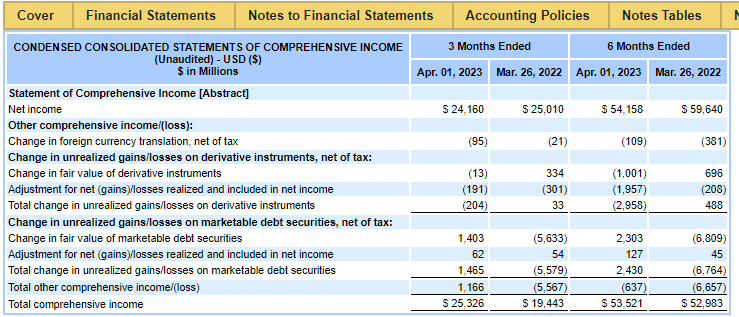



In [ ]:
def normalize_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        # Flatten multi-level columns
        df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

3) Define `get_10q_tabel()`, this function looks for the table under the specified heading in a list of many tables.

In [ ]:
def get_10q_tabel(restabel, keyword):
  for table in restabel:
    if keyword in table:
      return normalize_columns(table)

4) Define `data_comb()`, this function uses the functions outlined in 1 and 3 explicitly (and 2 implicitly as `normalize_columns()` is called within the `get_10q_tabel()` function and is implicitly invoked when `data_comb()` runs) and returns a list of many tables under some list of headings.

In [ ]:
def data_comb(links, keywordslist):
  res = []
  restabels = calls(links)
  for table in restabels:
    for keyword in keywordslist:
      res.append(get_10q_tabel(table, keyword))
  return res

5) For the balance sheet data we can join our separate tables on a common index and drop deplice dates, yielding a final data frame containing the combined balance sheet data across all 10-Qs for NVDA's 2023 financial year, we call this function `custom_join()`.

*Here we use an advanced function `.reduce` from `functools` for more information on how this function can be used and how it works follow the link below.
https://www.geeksforgeeks.org/reduce-in-python/*

In [ ]:
def custom_join(df_list, key_column, join_type = 'inner'):
    def join_func(df1, df2):
        return pd.merge(df1, df2, on=key_column, how=join_type)
    data = reduce(join_func, df_list) # apply reduce to df_list
    data = data.T.drop_duplicates().T
    return data



6) This function `tables_to_dataframe()`, can be called to insure we transform all data in our list of tabels to pandas data frame format although by default this should already be the case


In [ ]:
def tables_to_dataframe(tables_list):
  dataframes = []
  for table in tables_list:
    dataframes.append(pd.DataFrame(table))
  return dataframes

#**Simple Example:**

here we implement the simple example, where we whant to retrive only one table from the 10-Q .html file

The follwing links are sourced from the following page, https://investor.nvidia.com/financial-info/sec-filings/default.aspx

*The link should take you to a page that looks similer to the image below*

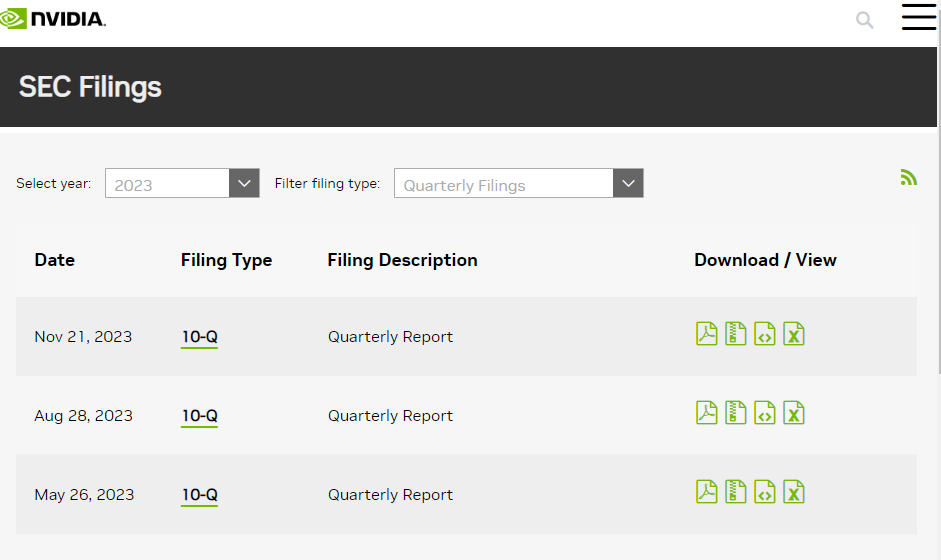


In [ ]:
# define the 10-Q links
urls = ["https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/ac7583b0-c5c4-402a-bb92-41e18a7f0e1e.html",
        "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/b08364d3-d2bb-415c-922d-67acdff93a3e.html",
        "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/529f61bd-50ca-46e4-bdf0-75640e8d29ba.html"]

# the key word
metadata = ["CONDENSED CONSOLIDATED BALANCE SHEETS - USD ($)  $ in Millions"]

In [ ]:
# get all tabels
res_dict = data_comb(urls, metadata)
# res_dict

In [ ]:
# join and drop
final_data = custom_join(res_dict, metadata)
final_data

,CONDENSED CONSOLIDATED BALANCE SHEETS - USD ($) $ in Millions,"Apr. 30, 2023","Jan. 29, 2023_x","Jul. 30, 2023","Oct. 29, 2023"
0,Current assets:,NaN,NaN,NaN,NaN
1,Cash and cash equivalents,"$ 5,079","$ 3,389","$ 5,783","$ 5,519"
2,Marketable securities,10241,9907,10240,12762
3,"Accounts receivable, net",4080,3827,7066,8309
4,Inventories,4611,5159,4319,4779
5,Prepaid expenses and other current assets,872,791,1389,1289
6,Total current assets,24883,23073,28797,32658
7,"Property and equipment, net",3740,3807,3799,3844
8,Operating lease assets,1094,1038,1235,1316
9,Goodwill,4430,4372,4430,4430


#**Multi Meta Data Example:**

In [ ]:
# the key word
metadatas = ["CONDENSED CONSOLIDATED BALANCE SHEETS - USD ($)  $ in Millions",
            'CONDENSED CONSOLIDATED STATEMENTS OF INCOME - USD ($)  shares in Millions, $ in Millions']

In [ ]:
# get all tabels
res_dict_multi = data_comb(urls, metadatas)
# res_dict_multi

In [ ]:
final_data_multi = tables_to_dataframe(res_dict_multi)
final_data_multi[5]

,"CONDENSED CONSOLIDATED STATEMENTS OF INCOME - USD ($) shares in Millions, $ in Millions CONDENSED CONSOLIDATED STATEMENTS OF INCOME - USD ($) shares in Millions, $ in Millions","3 Months Ended Oct. 29, 2023","3 Months Ended Oct. 30, 2022","9 Months Ended Oct. 29, 2023","9 Months Ended Oct. 30, 2022"
0,Income Statement [Abstract],NaN,NaN,NaN,NaN
1,Revenue,"$ 18,120","$ 5,931","$ 38,819","$ 20,923"
2,Cost of revenue,4720,2754,11309,9400
3,Gross profit,13400,3177,27510,11523
4,Operating expenses,NaN,NaN,NaN,NaN
5,Research and development,2294,1945,6210,5387
6,"Sales, general and administrative",689,631,1942,1815
7,Acquisition termination cost,0,0,0,1353
8,Total operating expenses,2983,2576,8152,8555
9,Operating income,10417,601,19358,2968


#**Multi Asset Example:**

Here we repeat the simple example with the addition of APPL 10q data

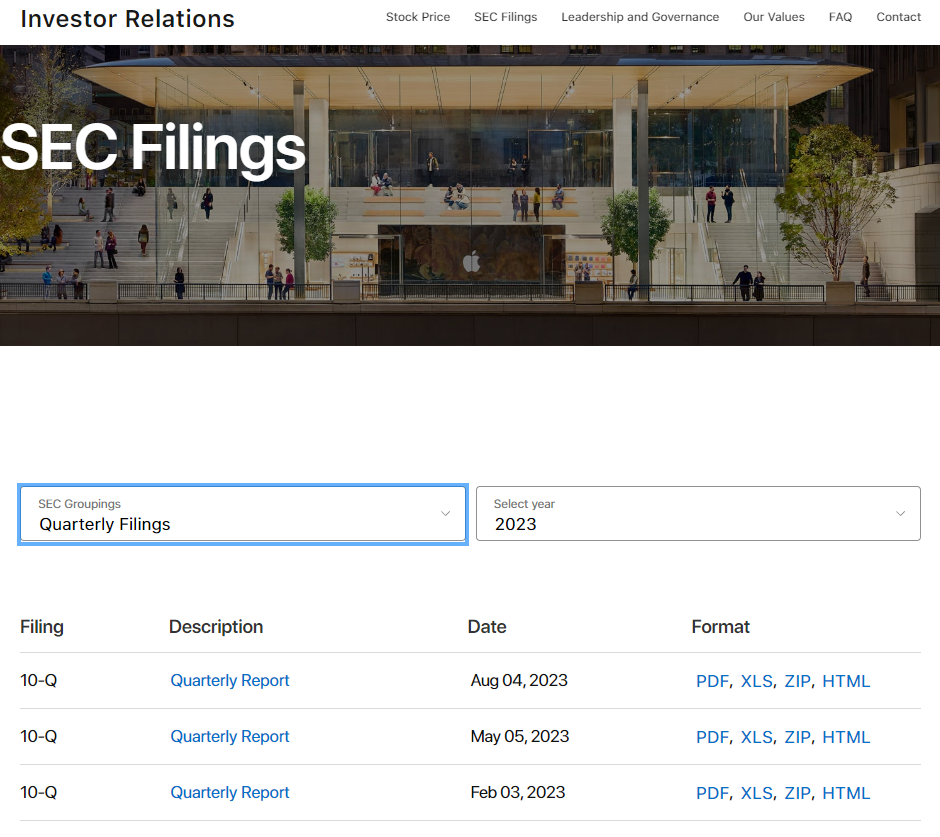

the following links are sourced from https://investor.apple.com/sec-filings/default.aspx



In [ ]:
# define the 10-Q links
urls_nvda = ['https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/ac7583b0-c5c4-402a-bb92-41e18a7f0e1e.html',
        'https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/b08364d3-d2bb-415c-922d-67acdff93a3e.html',
        'https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/529f61bd-50ca-46e4-bdf0-75640e8d29ba.html']

urls_aapl = ['https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/f76c20b9-23d2-4264-b2dd-8245afd8a979.html',
             'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/bf193322-3ae1-460b-a5a1-43a34a1fb957.html',
             'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/386e8c01-2795-4676-866f-9c816f935a42.html',]

# the key word
metadata_nvda = ['CONDENSED CONSOLIDATED BALANCE SHEETS - USD ($)  $ in Millions']
metdadata_aapl = ['CONDENSED CONSOLIDATED BALANCE SHEETS (Unaudited) - USD ($)  $ in Millions']

In [ ]:
# get all tabels
res_dict_nvda = data_comb(urls_nvda, metadata_nvda)
res_dict_aapl = data_comb(urls_aapl, metdadata_aapl)

In [ ]:
# join and drop
final_dat_nvda = custom_join(res_dict_nvda, metadata_nvda)
final_data_aapl = custom_join(res_dict_aapl, metdadata_aapl)

In [ ]:
final_data_aapl

,CONDENSED CONSOLIDATED BALANCE SHEETS (Unaudited) - USD ($) $ in Millions,"Jul. 01, 2023","Sep. 24, 2022_x","Dec. 31, 2022","Sep. 24, 2022_y","Apr. 01, 2023","Sep. 24, 2022"
0,Current assets:,NaN,NaN,NaN,NaN,NaN,NaN
1,Cash and cash equivalents,"$ 28,408","$ 23,646","$ 20,535","$ 23,646","$ 24,687","$ 23,646"
2,Marketable securities,34074,24658,30820,24658,31185,24658
3,Marketable securities,34074,24658,30820,24658,110461,120805
4,Marketable securities,34074,24658,114095,120805,31185,24658
5,Marketable securities,34074,24658,114095,120805,110461,120805
6,Marketable securities,104061,120805,30820,24658,31185,24658
7,Marketable securities,104061,120805,30820,24658,110461,120805
8,Marketable securities,104061,120805,114095,120805,31185,24658
9,Marketable securities,104061,120805,114095,120805,110461,120805
